# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/Zinser_SizeDist_regrid-20-12.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

### experimental part: shift down size classes

In [2]:
delta_v = 1.0/data_seaflow['delta_v_inv']
v = data_seaflow['v_min'] * 2**(np.arange(data_seaflow['m'])*delta_v) 

num_remove = 6

data_seaflow['v_min'] = v[num_remove]
w_obs = np.zeros_like(data_seaflow['w_obs'])
w_obs[:-num_remove] = data_seaflow['w_obs'][num_remove:,:]
data_seaflow['w_obs'] = w_obs

In [3]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

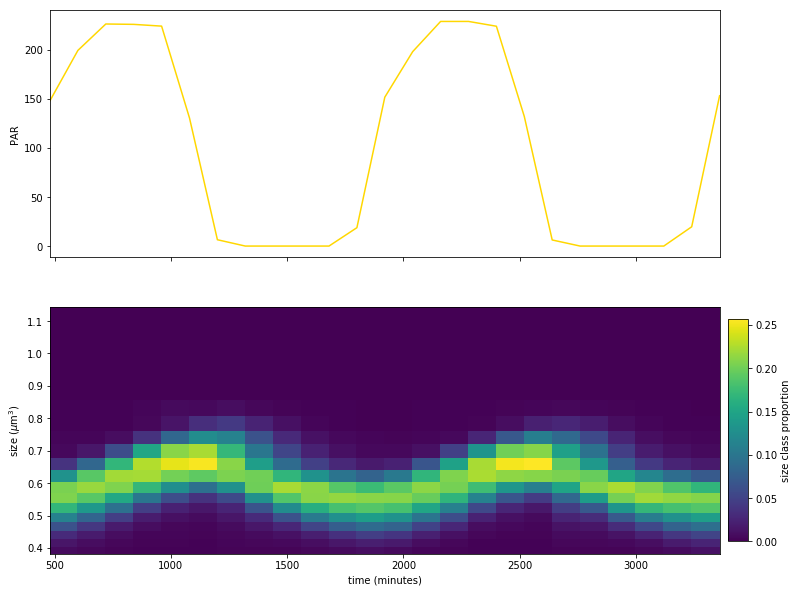

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [5]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

print(data['t_obs'])

[ 480  600  720  840  960 1080 1200 1320 1440 1560 1680 1800 1920 2040
 2160 2280 2400 2520 2640 2760]


In [6]:
import pystan

#model = pystan.StanModel(file='stancode/matrixmodel_freedelta_normparam_trackgrowth.stan')
model = pystan.StanModel(file='stancode/matrixmodel_freedelta_resp_normparam_trackgrowth.stan')
#model = pystan.StanModel(file='stancode/matrixmodel_freedelta_respi_gammai_normparam_trackgrowth.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3e59a6edea7a4051b9d1b2a01de27b61 NOW.


In [7]:
mcmc = model.sampling(data=data, iter=2000)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: anon_model_3e59a6edea7a4051b9d1b2a01de27b61.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.02    0.04   0.95   0.38   1.34   1.96   2.68    4.0    684   1.01
delta_sigma         0.96    0.03   0.72   0.09   0.42   0.79   1.33   2.74    428   1.01
delta_max[1]        1.07    0.05    0.9   0.04   0.37   0.81   1.53   3.28    334   1.01
delta_max[2]        1.91    0.04   1.29   0.15   0.97    1.7   2.58   5.02    983    1.0
delta_max[3]        2.17    0.05   1.43   0.23   1.11   1.91   2.88   5.62    988    1.0
delta_max[4]        2.13    0.05   1.45   0.15   1.07   1.88   2.86   5.67    942    1.0
delta_max[5]         2.1    0.04   1.39   0.18   1.09   1.85   2.81   5.48   1070   1.01
delta_max[6]        2.16    0.04   1.43   0.18   1.14   1.92   2.87   5.65   1032   1.01
delta_max[

## Plot the results

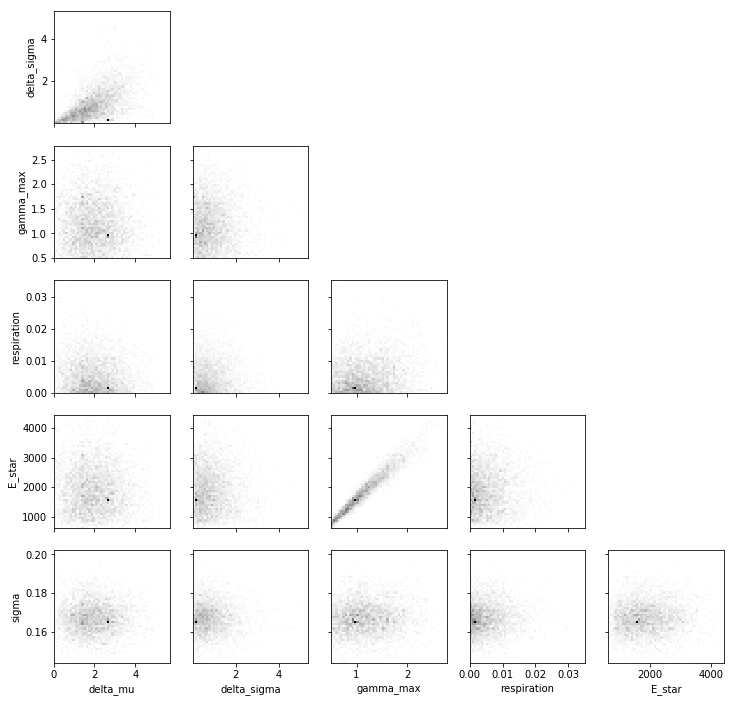

In [8]:
paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max')]
num_params = len(paramnames)

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames[icol]
        yname = paramnames[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)

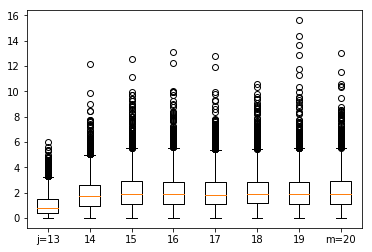

In [9]:
j = data_seaflow['delta_v_inv'] + 1
m = data_seaflow['m']
fig, ax = plt.subplots()
ax.boxplot(mcmc['delta_max'])
xlabels = [str(x) for x in range(j,m+1)]
xlabels[0] = 'j='+xlabels[0]
xlabels[-1] = 'm='+xlabels[-1]
ax.set_xticklabels(xlabels)
None

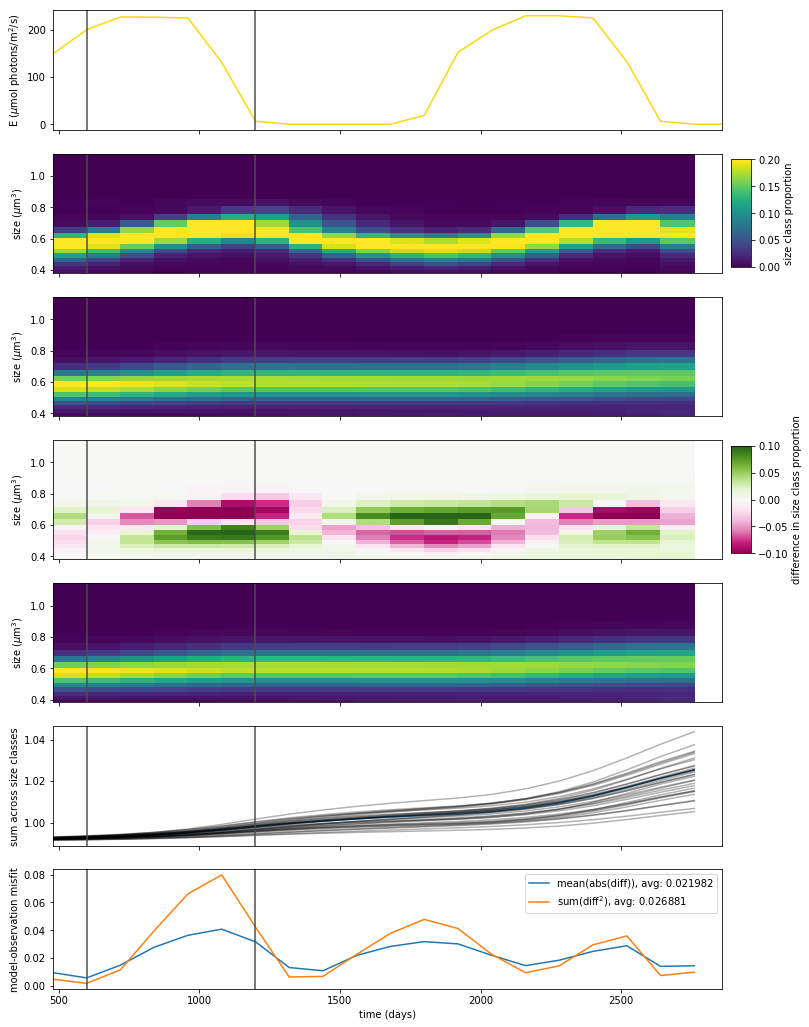

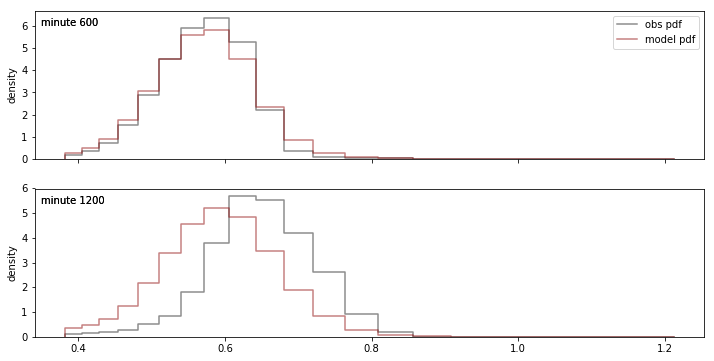

In [10]:
res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
colors = {'model':'darkred', 'obs':'0.1'}

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
diff = res_sum1-res['obs']


fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,18))

ax = axs[0]
ax.plot(t, data['E'], color='gold')
ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

ax = axs[2]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data['t_obs'],v,res_sum1,norm=norm)

ax = axs[3]
pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

ax = axs[4]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data['t_obs'],v,res['model'])

ax = axs[5]
ax.plot(data['t_obs'], np.sum(res['model'],axis=0))
ax.plot(data['t_obs'], np.sum(mcmc['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
ax.set(ylabel='sum across size classes')

ax = axs[6]
prop = np.mean(np.abs(diff),axis=0)
ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
prop = np.sum(diff**2,axis=0)
ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
ax.set(xlabel='time (days)', ylabel='model-observation misfit')
ax.legend()

for ax in axs.flat:
    for i in slice_indices:
        ax.axvline(data['t_obs'][i], color='.3')

# plot slices

plotdata_y = np.zeros(2*(data['m']+1))

fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
for i,ax in zip(slice_indices,axs.flat):
    for name in ('obs','model'):
        color = colors[name]
        cdata = res[name][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
        ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
        ax.set_ylabel('density')
        ax.set_ylim(bottom=0.0)
axs[0].legend()
None